In [1]:
!pip install gensim==4.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 9.0 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-4.1.2-cp310-cp310-macosx_10_9_universal2.whl size=24425947 sha256=88ef20229b2aa56cacb24c354222a710a3b6428048506a80073a3f67c353b3c2
  Stored in directory: /Users/prkskrs/Library/Caches/pip/wheels/4f/4e/73/8b69e5f901197006f4cfaadbb4926c707d5acee8b87e70b55f
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.2.0
    Uninstalling gensim-4.2.0:
      Successfully uninstalled gensim-4.2.0


In [240]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [241]:
# Will take 3-5 seconds to run
def load_fixed_train_df(original_train_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df


protein_dataset = load_fixed_train_df()
protein_dataset

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [242]:
from sklearn.model_selection import train_test_split
feature_columns = ["protein_sequence", "pH"]
target_columns = "tm"
X_train, X_test, y_train, y_test = train_test_split(protein_dataset[feature_columns], protein_dataset[target_columns], test_size=0.2, random_state=42)

In [243]:
from gensim import utils

class MyDataset:
    # creatign a wrapper to process a sentence
    def __iter__(self):
        for line in X_train['protein_sequence'].values.tolist():
            yield [*line]

In [244]:
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [245]:
import gensim.models
protein_seqs = MyDataset()
# training word2vec for our own dataset
model = gensim.models.Word2Vec(sentences=protein_seqs, min_count=10, vector_size=20, window=11, sg=1)

In [248]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 20), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for Acid {}'.format(word.title()))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


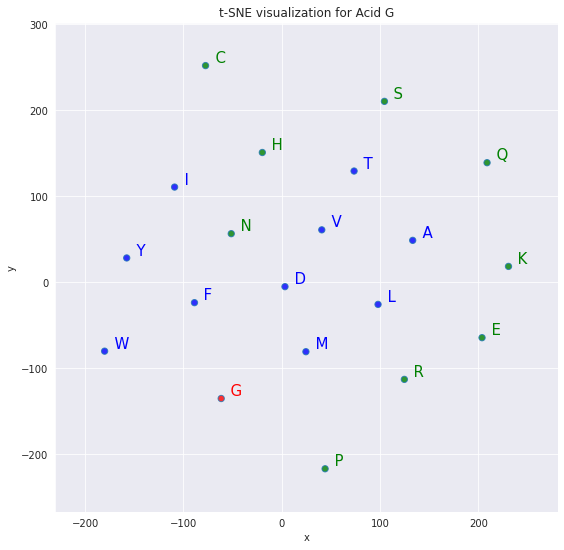

In [251]:
tsnescatterplot(model, 'G',[t[0] for t in model.wv.most_similar(positive=["G"], topn=20)][10:])

In [252]:
def getAverageVectors(sentence):
    tokens = [*sentence] # split sentence to tokens on space
    result = np.zeros(20) # start with zero result

    for token in tokens:
        # try except block helps in ignoring words that are not present in word2Vec model
        try: 
            result = np.add(result, model.wv[token])
        except:
            pass
    # find avgerage of the result
    result = result / len(tokens)
    return ','.join(map(str, result))


In [160]:
x_train_copy = X_train.copy()
x_train_copy['protein_sequence'] = x_train_copy['protein_sequence'].apply(lambda x: getAverageVectors(x))
x_train_copy

x_test_copy = X_test.copy()
x_test_copy['protein_sequence'] = x_test_copy['protein_sequence'].apply(lambda x: getAverageVectors(x))
x_test_copy

,protein_sequence,pH
16502,"-0.01007100484737127,0.020716818481138568,-0.0...",3.0
843,"-0.0019297180877411893,0.02377931755653567,-0....",7.0
5731,"0.0012389976143852243,0.007089151173850389,-0....",7.0
8663,"-0.0076030583364627095,0.009252273952006363,-0...",7.0
27605,"-0.002767845586134885,0.022326212941911748,-0....",7.0
...,...,...
18893,"0.00464730405672805,0.03380839553079834,0.0005...",7.0
2698,"-0.005680721333589066,0.017120178307999265,-0....",7.0
4199,"-0.010295576337912228,0.002239035001957661,-0....",7.0
11756,"-0.019038924893094084,0.0044116757211753125,0....",7.0


In [161]:
train = x_train_copy['protein_sequence'].str.split(',', -1, expand=True)
test = x_test_copy['protein_sequence'].str.split(',', -1, expand=True)

In [162]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5653,-0.00706682954747062,0.01996781248263679,-0.013601513556938886,-0.01077419164515025,0.034717422380397385,0.052683456591645104,-0.02132001722615363,0.025572076695761434,-0.0008094727317592851,0.007029286265343864,-0.07567065814090473,-0.05867228435804996,-0.08707858990512889,0.013089384874465313,-0.043677887445114354,-0.10073068651983196,0.282148170545026,-0.17623799561883682,-0.3917241754966813,0.4433238150568696
15912,-0.0013864726187148054,0.02203218482619284,0.004126875728351459,-0.014449601574878759,0.02737126940350991,0.04360691650919097,-0.011711142661667,0.03003467550506994,0.015308702600998775,0.003992990647578156,-0.08925564643629934,-0.049872565095820366,-0.07808278877094918,0.014014008626177469,-0.04130462270580382,-0.10628305586060688,0.2773202256337039,-0.19328804736547517,-0.36903954899347974,0.45759566815644964
20717,0.008983750991099323,0.02368557540650229,0.00013234988294686157,-0.006080677074359924,0.040763485880758045,0.04409194367300137,-0.011764170012840455,0.026934225969106752,0.0189247682271187,0.008414136009633578,-0.09445401626136199,-0.04720036891025782,-0.07217291057263174,0.012880380718391524,-0.03792636959529403,-0.0924403506982846,0.27535202020450017,-0.17923264435016648,-0.36526467479747377,0.4648126223762734
10385,-0.014656537184149743,0.01842433754565184,-0.015861016172668396,-0.02357154274569814,0.03668313008591027,0.04792766738255472,-0.03691827117644335,0.015225870158565415,-0.0018293998930287564,0.022958818406108663,-0.07477658808673338,-0.05530445968405354,-0.08224582351549492,0.01632837882682439,-0.041500098848094545,-0.0941805728200802,0.28546961540051097,-0.17149467802590737,-0.38698649835788596,0.45248867689216205
17694,-0.0027607195002569275,0.015161616015401516,-0.00015080481522030884,-0.008898828074254177,0.03362560819036194,0.04544883330076278,-0.013722334159947523,0.030260440236428283,0.010471057846814721,-0.00581040654310977,-0.07645532608359724,-0.05564638829129943,-0.08026164997788658,0.01530183477859412,-0.044401973073120014,-0.10628765613086276,0.2685603942189898,-0.18908442830728306,-0.38013727514298407,0.45223815690030106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,-0.012492351872273363,0.007536452074463551,-0.018506325041302122,-0.017089678195233528,0.039203591806670796,0.049402189390160715,-0.04947986584300032,-0.0017390944407536433,0.029132856185046525,0.023705318512108463,-0.08197748438096963,-0.04510261667408765,-0.07732452362131041,0.010787116155529825,-0.0424167232389132,-0.09101597213974366,0.2843617115570949,-0.18007546849262257,-0.3848179054260254,0.45235627348606405
5390,-0.01235045476940023,0.015049399836101087,-0.006373908302006143,-0.01705271949295897,0.03086481868227697,0.04687324411927229,-0.018279889892332302,0.027308368323236167,0.008138610585873207,0.013410791733683682,-0.07341634901240468,-0.04886937743955409,-0.08105097164144649,0.015565496498399067,-0.046196054089190274,-0.10226984125146844,0.2798702358660928,-0.1804323343879891,-0.3789964741073459,0.45639494752668475
860,0.007469163903071746,0.017867189762639065,-0.003439424139922302,-0.004786975855263425,0.040547943942924485,0.043420687925034,-0.013967232158243218,0.0249142186643154,0.01727036287935049,0.005141155684238993,-0.07966828092056162,-0.04693657712218827,-0.0733919514589669,0.013653007484105069,-0.04173683894229779,-0.09009340196555736,0.27144392816459434,-0.17931756841785768,-0.37222152854882035,0.4622417737455929
15795,-0.006360734793099951,0.00640353517271036,-0.005205395738912323,-0.004815933581395752,0.040161483699752046,0.046910731188253126,-0.024982667019932812,0.01982178420875501,0.03699982860245536,0.013944054913862471,-0.08127550237206169,-0.03887685566013189,-0.07059276071773406,0.009016335184695272,-0.04053967792375487,-0.08023869198687533,0.2706622867975363,-0.18664192322595724,-0.3725823687946409,0.46420805765292944


In [163]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
16502,-0.01007100484737127,0.020716818481138568,-0.017176734787559638,-0.01838827471067084,0.033554893479648434,0.04428525120637482,-0.027834068706951945,0.022566163781803192,-0.0066600590546774426,0.023225382931541833,-0.07381433594926465,-0.05617489168319635,-0.08785572220577018,0.021613334732203993,-0.046991639331880414,-0.10207899094263954,0.2886387793029227,-0.17216561115687576,-0.38954958955689173,0.4462877900862112
843,-0.0019297180877411893,0.02377931755653567,-0.00834142194433107,-0.014418369148811583,0.035440501508056006,0.04597573673905089,-0.020266163364201988,0.02615064098782714,-0.0018017498354391498,0.017375482372985897,-0.09290678693156545,-0.04780187087296894,-0.07391945272619779,0.01078674431378279,-0.03330525567945484,-0.08167433042017465,0.27826092009386305,-0.16912448384608683,-0.37657818321694325,0.4618160872004967
5731,0.0012389976143852243,0.007089151173850389,-0.004011220948533995,0.010207740919501648,0.05137561977385477,0.04124302048486774,-0.008916390827561784,0.035747224214369724,0.02933851521986389,0.005701084664190707,-0.08456084252553966,-0.04028246491230437,-0.07377215109535244,0.010584159224145268,-0.0436335854197164,-0.07296048162270928,0.268239850127469,-0.19371110432058614,-0.37851156066349945,0.4537248262942163
8663,-0.0076030583364627095,0.009252273952006363,-0.007099489257961977,-0.008877561647386756,0.042884880680503557,0.051200304302165024,-0.025608607086542178,0.022252029123774265,0.0216680995101342,0.008538175644571312,-0.07523174673260655,-0.048718221302260646,-0.0806891091830039,0.010738761683387565,-0.044826576664672754,-0.08844954155210871,0.27257075435481964,-0.18810596614348468,-0.3830053933430463,0.45266960957087576
27605,-0.002767845586134885,0.022326212941911748,-0.014901467121274868,-0.013510348025311862,0.037172027291603,0.05084247472553849,-0.03355155905377739,0.016681167367759712,0.007436348357913058,0.01682447942231994,-0.08225489993209821,-0.05627264224646748,-0.08249365308857856,0.012853009292391734,-0.03816170748876463,-0.08560006906933124,0.2783737979804722,-0.17400792114153849,-0.38857717925172436,0.4501042402747965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18893,0.00464730405672805,0.03380839553079834,0.0005486051171583292,-0.01709772429899984,0.03028631518707873,0.05542111212030177,-0.011331479349099014,0.04407142607380105,-0.010823214501227748,0.008859875509131794,-0.08926864562969596,-0.06562044752457497,-0.09265221716959703,0.015122803784022427,-0.03825755808963302,-0.09310025513359693,0.272900808559948,-0.18351527328818218,-0.3871547271512466,0.44572282949083186
2698,-0.005680721333589066,0.017120178307999265,-0.013564684618772431,-0.008854246488349005,0.04586079923097383,0.04947653078304773,-0.027237487305802378,0.023799184587868775,0.01784108394248919,0.023893042222004047,-0.07861710070886395,-0.04849666560703719,-0.08317168283614923,0.013414436663839627,-0.04504067326409065,-0.0810076702657071,0.28108067279512233,-0.1825027948347005,-0.381540029482408,0.4533358744057742
4199,-0.010295576337912228,0.002239035001957661,-0.013131519538927928,-0.021093346116096614,0.04251803377481937,0.05326284237088483,-0.04087985377781287,-0.0037498731769662996,0.015206931646240379,0.02667557115335316,-0.09530519445043481,-0.03702161445712074,-0.07100497939176441,0.0051061358210479834,-0.03425768390395444,-0.08363060594936989,0.29281802336707907,-0.16135882496750553,-0.3936704034800858,0.4478827433546162
11756,-0.019038924893094084,0.0044116757211753125,0.0017544928638969061,-0.017825186749621066,0.024778116402732586,0.050799784122078334,-0.011555332326151701,0.03350064806505034,0.019036370701122778,0.006021548932360321,-0.06165240773535454,-0.047774615654736334,-0.08680650024008912,0.015665217003558274,-0.05431100121371139,-0.11687763826680307,0.28271968693622035,-0.19647570032568484,-0.3842049920497163,0.44593287517987384


In [164]:
train.isnull().values.any()

False

In [165]:
from sklearn.impute import SimpleImputer
columns = [f'Acid {x+1}' for x in range(len(train.columns))]
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer1.fit(train)
train_data = pd.DataFrame(imputer1.transform(train), columns= columns)

imputer2 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer2.fit(train)
test_data = pd.DataFrame(imputer2.transform(test), columns=columns)

In [166]:
train_data

,Acid 1,Acid 2,Acid 3,Acid 4,Acid 5,Acid 6,Acid 7,Acid 8,Acid 9,Acid 10,Acid 11,Acid 12,Acid 13,Acid 14,Acid 15,Acid 16,Acid 17,Acid 18,Acid 19,Acid 20
0,-0.007067,0.019968,-0.013602,-0.010774,0.034717,0.052683,-0.021320,0.025572,-0.000809,0.007029,-0.075671,-0.058672,-0.087079,0.013089,-0.043678,-0.100731,0.282148,-0.176238,-0.391724,0.443324
1,-0.001386,0.022032,0.004127,-0.014450,0.027371,0.043607,-0.011711,0.030035,0.015309,0.003993,-0.089256,-0.049873,-0.078083,0.014014,-0.041305,-0.106283,0.277320,-0.193288,-0.369040,0.457596
2,0.008984,0.023686,0.000132,-0.006081,0.040763,0.044092,-0.011764,0.026934,0.018925,0.008414,-0.094454,-0.047200,-0.072173,0.012880,-0.037926,-0.092440,0.275352,-0.179233,-0.365265,0.464813
3,-0.014657,0.018424,-0.015861,-0.023572,0.036683,0.047928,-0.036918,0.015226,-0.001829,0.022959,-0.074777,-0.055304,-0.082246,0.016328,-0.041500,-0.094181,0.285470,-0.171495,-0.386986,0.452489
4,-0.002761,0.015162,-0.000151,-0.008899,0.033626,0.045449,-0.013722,0.030260,0.010471,-0.005810,-0.076455,-0.055646,-0.080262,0.015302,-0.044402,-0.106288,0.268560,-0.189084,-0.380137,0.452238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23179,-0.012492,0.007536,-0.018506,-0.017090,0.039204,0.049402,-0.049480,-0.001739,0.029133,0.023705,-0.081977,-0.045103,-0.077325,0.010787,-0.042417,-0.091016,0.284362,-0.180075,-0.384818,0.452356
23180,-0.012350,0.015049,-0.006374,-0.017053,0.030865,0.046873,-0.018280,0.027308,0.008139,0.013411,-0.073416,-0.048869,-0.081051,0.015565,-0.046196,-0.102270,0.279870,-0.180432,-0.378996,0.456395
23181,0.007469,0.017867,-0.003439,-0.004787,0.040548,0.043421,-0.013967,0.024914,0.017270,0.005141,-0.079668,-0.046937,-0.073392,0.013653,-0.041737,-0.090093,0.271444,-0.179318,-0.372222,0.462242
23182,-0.006361,0.006404,-0.005205,-0.004816,0.040161,0.046911,-0.024983,0.019822,0.037000,0.013944,-0.081276,-0.038877,-0.070593,0.009016,-0.040540,-0.080239,0.270662,-0.186642,-0.372582,0.464208


In [167]:
train_data.isnull().values.any()
test_data.isnull().values.any()

False

# Feed Forward Network

In [168]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [169]:
# Define a DataLoader 

# Train Dataloader
class TrainReview(Dataset):
    
    # Initialize class variables
    def __init__(self, X, y, transform=torch.tensor):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    # Overwrite __getitem__ method
    def __getitem__(self, index):
       
        review = self.X.iloc[index]
        label = self.y.iloc[index]
        
        if self.transform is not None:
            review = self.transform(review, dtype=torch.float32)
            label = self.transform(label, dtype=torch.float32)

        return review,label
      

# Test data loader
class TestReview(Dataset):
    
    # initialize class variables
    def __init__(self, X, y, transform=torch.tensor):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    # Overwrite __getitem__ method
    def __getitem__(self, index):
        review = self.X.iloc[index]
        labels = self.y.iloc[index]

        if self.transform is not None:
            review = self.transform(review, dtype=torch.float32)
            labels = self.transform(labels, dtype=torch.float32)
          
        return review,labels

In [170]:
X_train,X_test,y_train,y_test = train_test_split(train_data,y_train,test_size=0.2, random_state=42)

In [171]:
# Define train and test loaders
train_data = TrainReview(X_train,y_train-1)
test_data = TestReview(X_test,y_test-1)

In [172]:
num_workers = 0
batch_size = 20
valid_size = 0.2

# get indexes for validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Sample training set to split into train and validation set
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size,
                          sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Define FF Network

In [225]:
# Construct A Feed-Forward Neural Net
# Reference - https://www.kaggle.com/code/mishra1993/pytorch-multi-layer-perceptron-mnist/notebook
class FeedForward(nn.Module):
    def __init__(self, D_in,D_out):
        super(FeedForward, self).__init__()

        # Set sizes of hidden layers
        hidden_1 = 20
        hidden_2 = 20

        # Initailize input dimension and output dimension
        self.input_size = D_in
        self.output_size = D_out

        # Construct the Neural net structure
        self.fc1 = nn.Linear(self.input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, self.output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add hidden layer 1
        x = F.relu(self.fc1(x))
#         X = self.fc1(x)
        x = self.dropout(x)

        # add hidden layer 2
        x = F.relu(self.fc2(x))
#         x = self.fc2(x)
        x = self.dropout(x)
        
        # add output layer
        x = self.fc3(x)

        return x
      

In [226]:
# Helper Functions to check Model Evaluation

# Define function to evaluate model
def evaluate(model, loader, text = "Model"):
        
    model.eval()
    correct_predictions = 0
    total = 0

    # Get data from data loader and get predicted values
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device)
            y = y.to(device=device)

            scores = model(X)

            _, predictions = scores.max(1)

            # Get the number of correct predictions 
            correct_predictions += (predictions == y).sum()
            total += predictions.size(0)
    # Calculate Accuracy
    accuracy = float(correct_predictions) / float(total)

    return f'{text} gives Accuracy of : {accuracy}'

In [227]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [232]:
# Initialize a Network instance
model = FeedForward(20,1)
print(model)

# Loss function and optimizer
criterion = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

FeedForward(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [233]:
# number of epochs to train the model
n_epochs = 100

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Prepare model for training
    model.train() 
    for data, target in train_loader:

        # Load to device
        data,target = data.to(device),target.to(device)
        
        # Start training the model
        optimizer.zero_grad()
        output = model(data)
        
        # Reshape to fit data
        output = torch.reshape(output, (output.size()[0],))
        
        # calculate loss function and perform back propogation
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        # update running training loss
        train_loss += loss.item()*data.size(0)

    # Perform validation
    model.eval() 
    for data, target in valid_loader:
        
        # Load to device
        data,target = data.to(device),target.to(device)
        output = model(data)
        
        # Reshape to fit data
        output = torch.reshape(output, (output.size()[0],))
        
        # Calculate loss function
        loss = criterion(output, target)

        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss / len(train_loader):.6f} \tValidation Loss {valid_loss / len(valid_loader):.6f}')


Epoch: 1 	Training Loss: 0.039122 	Validation Loss 0.008526
Epoch: 2 	Training Loss: 0.012910 	Validation Loss 0.008971
Epoch: 3 	Training Loss: 0.012298 	Validation Loss 0.008486
Epoch: 4 	Training Loss: 0.011807 	Validation Loss 0.008478
Epoch: 5 	Training Loss: 0.011672 	Validation Loss 0.008435
Epoch: 6 	Training Loss: 0.011384 	Validation Loss 0.008556
Epoch: 7 	Training Loss: 0.011194 	Validation Loss 0.008456
Epoch: 8 	Training Loss: 0.011017 	Validation Loss 0.008394
Epoch: 9 	Training Loss: 0.010831 	Validation Loss 0.008396
Epoch: 10 	Training Loss: 0.010635 	Validation Loss 0.008376
Epoch: 11 	Training Loss: 0.010577 	Validation Loss 0.008451
Epoch: 12 	Training Loss: 0.010489 	Validation Loss 0.008437
Epoch: 13 	Training Loss: 0.010386 	Validation Loss 0.008370
Epoch: 14 	Training Loss: 0.010411 	Validation Loss 0.008668
Epoch: 15 	Training Loss: 0.010298 	Validation Loss 0.008372
Epoch: 16 	Training Loss: 0.010270 	Validation Loss 0.008459
Epoch: 17 	Training Loss: 0.01019

In [234]:
print(output,target)

tensor([46.8605, 46.2019, 49.1326, 46.0305, 48.2928, 46.0495, 46.0020, 46.0012,
        46.0196], grad_fn=<ReshapeAliasBackward0>) tensor([32.8000, 36.6000, 48.3000, 37.7000, 40.0000, 47.2000, 47.9000, 56.2000,
        49.2000])


### Evaluation Function

In [5]:
evaluate(model, train_loader,"Feed Forward Network")

Feed Forward Network gives Accuracy of : 0.298765


### Plotting Protien Similarities